### Tutorial of spatial imputation on slice #151673 of DLPFC using CPS

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2026'])
args.prep_scale = False
args.sigma=1.0
args.freq = 32
args.hvgs=3000
args.er_w = 0.05
args.max_epoch=1000
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/1-DLPFC/'
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
args

Namespace(batch_size=1024, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/1-DLPFC/', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, embedd_dim=512, er_w=0.05, flow='source_to_target', freq=32, gpu=0, hvgs=3000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2026, self_loops=True, sigma=1.0, weight_decay=0.0001)

In [4]:
section = '151673'
mask_ratio = 0.5
adata = sc.read_visium(os.path.join(args.dataset_path+section))
Ann_df = pd.read_csv(os.path.join(args.dataset_path+'1-DLPFC_annotations/', section+'_truth.txt'), 
                     sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs, layer='counts')
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, zero_center=True, max_value=10)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
spatial_data = CPS.SpatialGraphBuilder(args)
train_data, test_data, train_indices, _ = spatial_data.spots_perturb(adata_hvg, mask_ratio=mask_ratio)
print(train_data)

Data(x=[1820, 3000], edge_index=[2, 15318], y=[1820, 3000], pos=[1820, 2], num_nodes=1820, num_genes=3000)


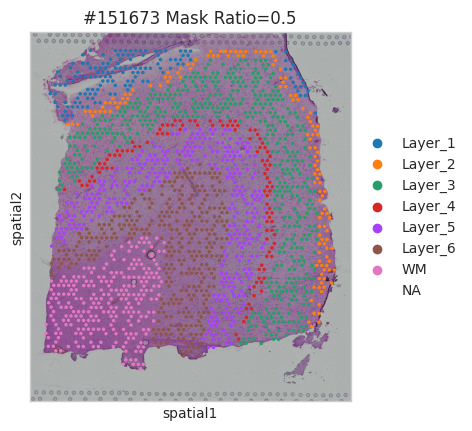

In [7]:
sc.pl.spatial(adata_hvg[train_indices], img_key="hires", 
              color=["Ground Truth"], 
              title=[f'#{section} Mask Ratio={mask_ratio}'])

In [8]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(train_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.05197871848940849 2.0792951583862305

Epoch   0: Train[Total:2.7589, T:1.0400, S:0.9479, D:0.7710]
0.05197805166244507 2.079281806945801
0.05197754129767418 2.0792715549468994
0.05197695642709732 2.0792598724365234
0.051975417882204056 2.0792291164398193
0.05197444185614586 2.079209566116333
0.05197324976325035 2.079185724258423
0.051971759647130966 2.079155921936035
0.051971305161714554 2.0791468620300293
0.05197000503540039 2.0791208744049072
0.051969122141599655 2.0791032314300537

Epoch  10: Train[Total:1.3700, T:0.5581, S:0.5042, D:0.3077]
0.05196578428149223 2.0790364742279053
0.051965560764074326 2.0790319442749023
0.05196500942111015 2.0790209770202637
0.05196204409003258 2.0789616107940674
0.05196213722229004 2.0789635181427
0.05196034908294678 2.078927755355835
0.051956355571746826 2.078847885131836
0.051955174654722214 2.078824281692505
0.05195334181189537 2.0787875652313232
0.05194992944598198 2.0787193775177

Epoch  20: Train[Total:1.2896, T:0.5443, S:0.4924, D:0.2530]
0

Compute the metrics on test dataset

In [9]:
metrics = cps_model.evaluate_spots_imputation(test_data=test_data, experiment_name='DLPFC_SI', use_log1p=True)

Performing spots imputation, number of test spots: 1819

Computing metrics on **Log1p Transformed** data...

Spatial imputation metrics [Log1p Transformed]

[global flatten metrics]
MSE:           0.061384
RMSE:          0.247759
MAE:           0.134095
R²:            0.640995
Pearson:       0.805864
Spearman:      0.497984

[sample mean metrics]
CS:               0.798481
CS nonzero:       0.895955
Pearson:          0.770774
Pearson nonzero:  0.775042
Spearman:         0.482607
Spearman nonzero: 0.638709
SAM:              36.587959°
SAM nonzero:      26.368621°
MSE:              0.061384
MSE nonzero:      0.266962
MAE:              0.134095
MAE nonzero:      0.445482

 num of sample: 1819.0
Metrics saved to: ./results/DLPFC_SI_metrics.json


### Analysis of the imputed gene expression

In [10]:
# mask_ratio=0 to get all the inference data
train_data, _, _, _ = spatial_data.spots_perturb(adata_hvg, mask_ratio=0.)
imputed_expr, z_s = cps_model.infer_postion(train_data)
imputed_expr.shape

torch.Size([3639, 3000])

In [11]:
adata_hvg.layers['imputed'] = imputed_expr.detach().cpu().numpy()
adata_hvg.obsm['z_s'] = z_s.detach().cpu().numpy()
adata_hvg

AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'hvg_features', 'hvg_counts', 'z_s'
    layers: 'counts', 'imputed'

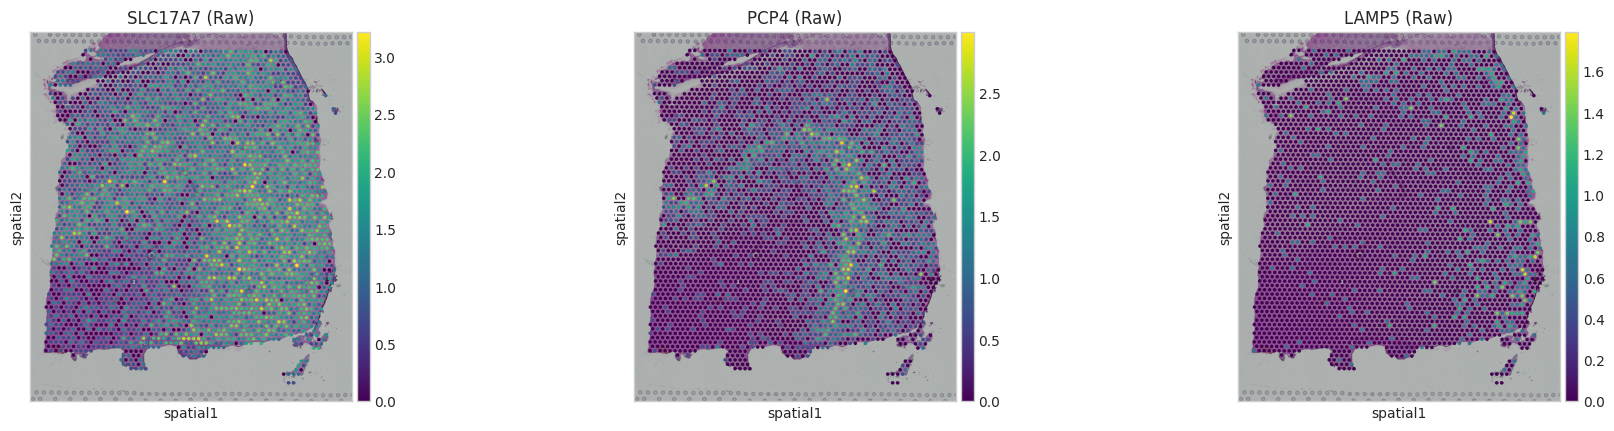

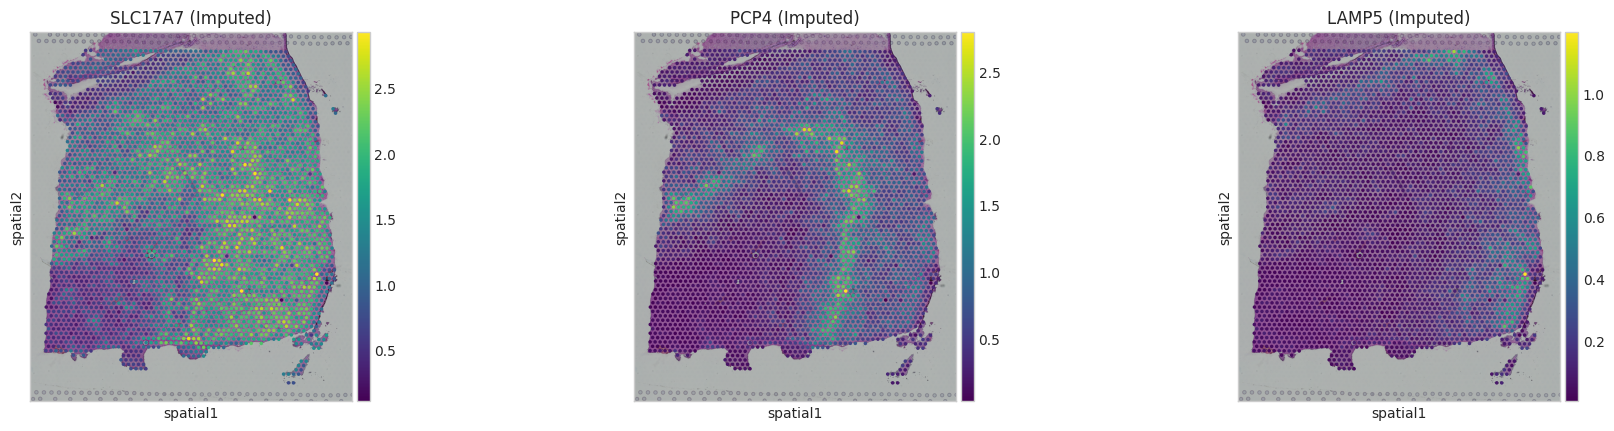

In [12]:
import numpy as np
adata_hvg.layers['log1p_raw'] = np.log1p(adata_hvg.layers['counts']) 
adata_hvg.layers['log1p_imputed'] = np.log1p(adata_hvg.layers['imputed'])
genes_to_plot = ['SLC17A7', 'PCP4', 'LAMP5']

sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_raw', 
              title=[f"{g} (Raw)" for g in genes_to_plot], ncols=3)
sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_imputed',
              title=[f"{g} (Imputed)" for g in genes_to_plot], ncols=3)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


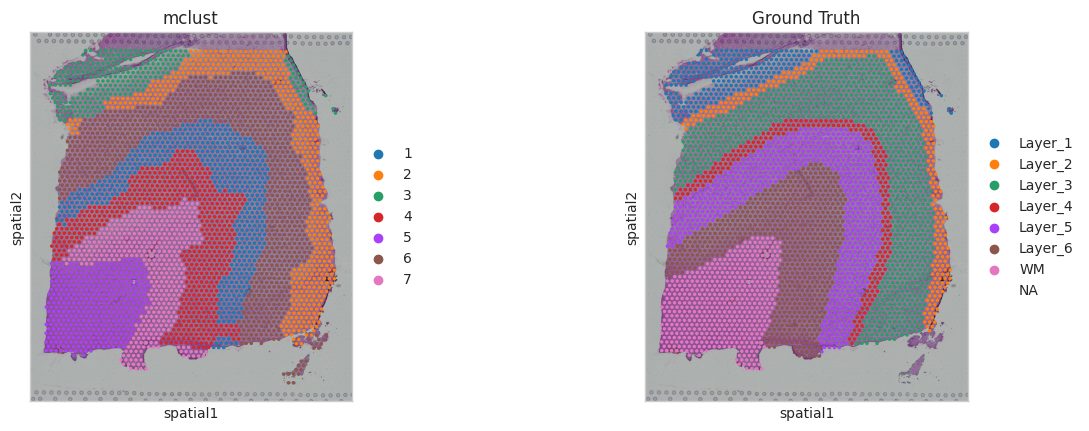

[<Axes: title={'center': 'mclust'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Ground Truth'}, xlabel='UMAP1', ylabel='UMAP2'>]

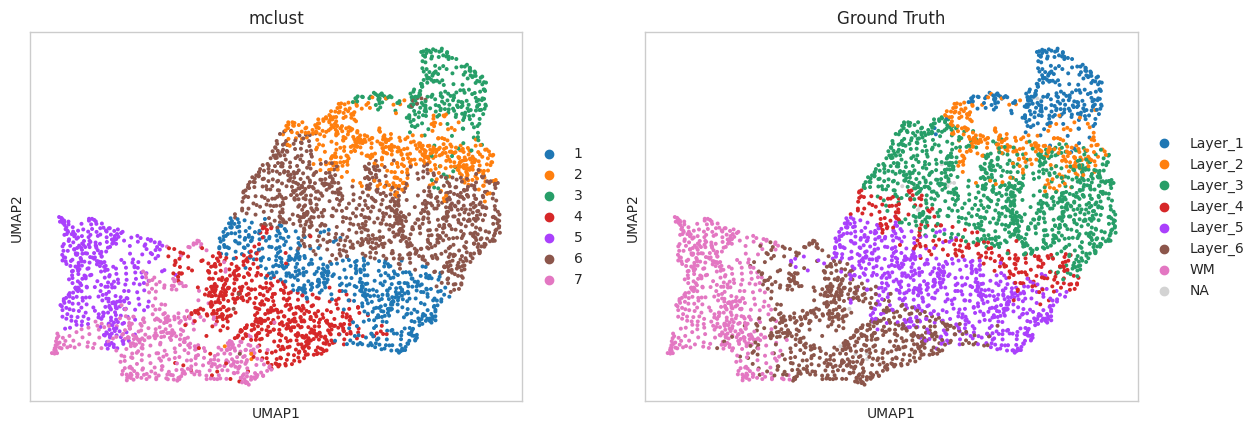

In [13]:
adata_hvg = CPS.mclust(adata_hvg, args, key='z_s', pca_dim=32, refine=True)

sc.pl.spatial(adata_hvg, img_key="hires", color=["mclust",'Ground Truth'])
sc.pp.neighbors(adata_hvg, n_neighbors=15, use_rep='z_s')
sc.tl.umap(adata_hvg)
sc.pl.embedding(adata_hvg, basis='umap', color=["mclust", "Ground Truth"], show=False)

In [1]:
# adata_hvg.X = adata_hvg.layers['imputed']
# sc.pp.log1p(adata_hvg)
# sc.pp.scale(adata_hvg, zero_center=True)

# sc.pp.pca(adata_hvg, n_comps=32)
sc.pp.neighbors(adata_hvg, use_rep='z_s')
sc.tl.umap(adata_hvg)

adata_hvg = adata_hvg[adata_hvg.obs['Ground Truth'].notna(),:]
sc.tl.paga(adata_hvg, groups='Ground Truth')
sc.pl.paga_compare(adata_hvg, frameon=False, size=50, 
                   legend_fontoutline=2, show=False)

NameError: name 'sc' is not defined